<a href="https://colab.research.google.com/github/ymiftah/operations_research/blob/master/dyeing_plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -qq pyomo
!apt-get install -qq coinor-cbc

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Dyeing plant

<img src="https://www.organicdye.com/wp-content/uploads/2017/01/PowderDyePiles_Opt700x200.jpg" width="80%" alt="dye">

## Problem Statement
A fabric dyeing plant has 3 dyeing baths. Each batch of fabric must be dyed in each bath in the order: ﬁrst, second, third bath. The plant must colour ﬁve batches of fabric of diﬀerent sizes. Dyeing batch i in bath j takes a time sij expressed in hours in the matrix below: 


$  \left[\begin{array}
{rrr}
3 & 1 & 1 \\
3 & 1.5& 1 \\
3 & 1.2 & 1.3 \\
2 & 2 & 2 \\
2.1 & 2 & 3
\end{array}\right]$


**Schedule the dyeing operations in the baths so that the ending time of the last batch is minimized**

In [0]:
from pyomo.environ import *

# create a model
model = ConcreteModel()

batch =   [str(i) for i in range(1,6)]
bath = [str(i) for i in range(1,4)]
sij = [[  3,   1,   1],
       [  2, 1.5,   1],
       [  3, 1.2, 1.3],
       [  2,   2,   2],
       [2.1,   2,   3]
       ]
time = {(batch[i], bath[j]): sij[i][j]
        for i in range(len(batch))
        for j in range(len(bath))}
bigM = 1000


# Sets
model.batch = Set(initialize=batch)
model.bath = Set(initialize=bath, ordered=True)
model.order = Set(initialize=batch, ordered=True)

## Declare decision variables
# The starting time of batch i in bath j
model.start_time = Var(model.batch, model.bath,
                       domain=NonNegativeReals)
# The ending time of the last dyeing process
model.last_time = Var(domain=NonNegativeReals)
# Binary variable to ensure correct succesion of actions
# m.prec[x, y, b] = 1 if batch x precedes batch y in bath b.
model.prec = Var(model.batch, model.batch, model.bath,
                 domain=Binary)

# declare objective
# We want to minimize the ending time of the last deying process
model.obj = Objective(expr = model.last_time,
                       sense=minimize)

#############################
##   Constraints
#############################

def cstr_disjunction(m, x, y, b):
    if x == y:
        # We put a constraint only for x =/= y
        return Constraint.Skip
    else:
        # For all baths, a batch necessarily precedes another
        return m.prec[x, y, b] + m.prec[y, x, b] == 1

def cstr_seq(m, x, b):
    # Batche x start at bath b only if it finished going through bath b-1
    if b != m.bath.last():
        return m.start_time[x, b] + time[x, b] <= m.start_time[x, m.bath.next(b)]
    else:
        # For the last batch the specific condition defines the ending time of
        # The process
        return m.start_time[x, b] + time[x, b] <= m.last_time

def cstr_nonoverlap(m, x, y, b):
    if x == y:
        # Constraint only applies for distinct batches
        return Constraint.Skip
    else:
        # For all baths,
        # if batch d precedes batch dd, batch dd can only go through bath b
        # after batch d finishes
        # The bigM must be bigger than the longest possible time
        return m.start_time[x, b] + time[x, b] <= m.start_time[y, b] + bigM * (1 - m.prec[x, y, b])


model.seq = Constraint(model.batch, model.bath, rule=cstr_seq)
model.nonoverlap = Constraint(model.batch, model.batch, model.bath, rule=cstr_nonoverlap)
model.disjunction = Constraint(model.batch, model.batch, model.bath, rule=cstr_disjunction)

In [5]:
# Solve the problem
sol = SolverFactory('cbc', executable='/usr/bin/cbc').solve(model)
sol.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 14.1
  Upper bound: 14.1
  Number of objectives: 1
  Number of constraints: 75
  Number of variables: 46
  Number of binary variables: 60
  Number of integer variables: 60
  Number of nonzeros: 1
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.82
  Wallclock time: 0.85
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 


## Results

Let us visualize in a table the task assignment

In [6]:
start_times = model.start_time.extract_values()

start_times = pd.DataFrame(
    [[start_times[j,i] for j in batch] for i in bath],
    columns=batch,
    index=bath,
    dtype='int'
)

end_times = start_times + np.array(sij).T

print('Start times\n', start_times)
print('*'*30)
print('End times\n', end_times)

Start times
       1     2    3    4    5
1   9.1   7.1  4.1  2.1  0.0
2  12.1   9.1  7.1  5.1  2.1
3  13.1  10.6  9.1  7.1  4.1
******************************
End times
       1     2     3    4    5
1  12.1   9.1   7.1  4.1  2.1
2  13.1  10.6   8.3  7.1  4.1
3  14.1  11.6  10.4  9.1  7.1


The completion time for all tasks is 14.1 seconds

In [7]:
print('Completion time = ', model.obj(), 'seconds')

Completion time =  14.1 seconds


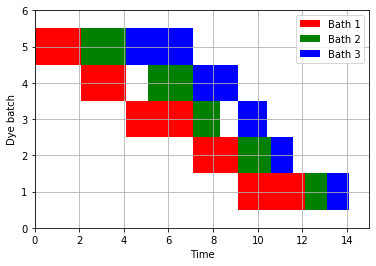

In [8]:
# Create figure and axes
fig,ax = plt.subplots(1)
ax.set_xlim(0,15)
ax.set_ylim(0,6)
ax.set_ylabel('Dye batch')
ax.set_xlabel('Time')


# Create a Rectangle patch
colors = dict(zip(bath, ['r', 'g', 'b']))
for i, d in enumerate(batch):
    for j, b in enumerate(bath):
        rect = patches.Rectangle((start_times.iloc[j,i], i+.5), sij[i][j],1,linewidth=1,
                         facecolor=colors[b])

        # Add the patch to the Axes
        ax.add_patch(rect)

legend_elements = [patches.Patch(facecolor=colors[b], label='Bath '+ b) for b in bath]
ax.legend(handles=legend_elements)
plt.grid(True)
plt.show()